# Data analysis and wrangling

## Dependencies

In [59]:
"""
Fetch and analysis the following datasets:
    [-] MIMIC-3 from the server in COMP-WELL lab
    [x] Adult Census dataset from Fairlearn
    [-] Intersectional bias assessment for depression prediction from OpenML

docs for fetch_openml: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html 
"""

from sklearn.datasets import fetch_openml
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import count, selection_rate, false_positive_rate, false_negative_rate
from fairlearn.metrics import false_negative_rate, false_positive_rate
from fairlearn.metrics import mean_prediction, selection_rate
from fairlearn.metrics import true_negative_rate, true_positive_rate
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [60]:
PLOTS_PATH ="./plots/"
DATA = {}
ACS_INCOME = "ACSincome"
IBADepression = "IBADepression"
RAC1P_MAP = {
    1.0: "White alone",
    2.0: "Black or African American alone",
    3.0: "American Indian alone",
    4.0: "Alaska Native alone",
    5.0: "American Indian and Alaska native tribes specified",
    6.0: "Asian alone",
    7.0: "Native Hawaiian and Other Pacific Islander alone",
    8.0: "Some Other Race alone",
    9.0: "Two or More races"
}
RACIP_CODES = ["WHIT", "BLCK", "AMIN", "ALSK", "AITR", "ASIA", "NHPI", "SORA", "TMRC"]
SEX_MAP = {
    1.0: "Male",
    2.0: "Female"
}

## Fetching data

In [61]:
def fetch_openml_dataset(choice):
    """Load dataset according to the choice from OpenML.
    
    Args:
        choice (str): dataset name
    
    Returns:
        X (pd.Dataframe): features
        y_true (pd.Series): true labels
    """
    if choice == ACS_INCOME:
        data = fetch_openml(data_id=43141, as_frame=True, parser='auto')
    elif choice == IBADepression:
        data = fetch_openml(data_id=45040, as_frame=True, parser='auto')

    X = pd.get_dummies(data.data)
    y_true = data.target
    return {"features": X, "labels": y_true}

In [62]:
def test_fetch_openml_dataset():
    """Test fetch_openml_dataset function."""
    DATA[ACS_INCOME] = fetch_openml_dataset(ACS_INCOME)
    DATA[IBADepression] = fetch_openml_dataset(IBADepression)


test_fetch_openml_dataset()

## Data analysis

Feature-side analysis:

- Unbalance in the data
    - `plot_val_counts()`
- Correlated features
    - `plot_corr_heatmap()`
- Mislabelling due to discrimination (difficult to detect, so we skip it for now)

Target-side analysis:

- Outcome distribution
    - `plot_target_dist()`

In [63]:
def plot_val_counts(features, col_name, xmapping, xlabel, ylabel, title, save_path=None):
    """Plot bar chart visualizing the value counts of a column in the dataframe.
    
    Args:
        features (pd.Dataframe): features dataframe
        col_name (str): column name
        xmapping (dict): mapping from the value to the label
        xlabel (str): x-axis label
        ylabel (str): y-axis label
        title (str): title of the plot
        save_path (str): path to save the plot
        
    Returns:
        fig (matplotlib.figure.Figure): figure
    """
    fig, ax = plt.subplots()
    val_counts_series = features[col_name].value_counts().rename(xmapping)
    keys = list(val_counts_series.keys())
    vals = list(val_counts_series.values)
    ax.bar(keys, vals)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(keys)
    ax.set_xticklabels(keys, rotation=45, ha='right')
    if save_path:
        fig.savefig(save_path + title + ".png", bbox_inches='tight')
    return fig

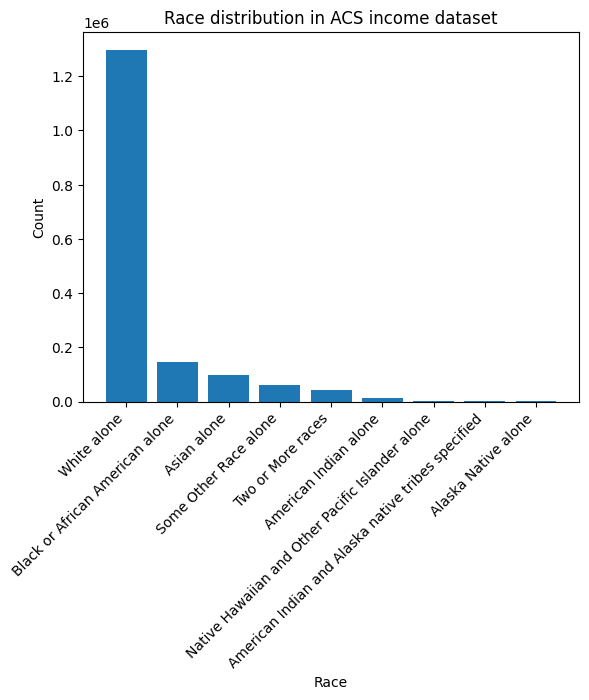

In [64]:
def test_plot_val_counts():
    """Test plot_val_counts function."""
    plot_val_counts(DATA[ACS_INCOME]["features"], 'RAC1P', RAC1P_MAP, 'Race', 'Count',
                    'Race distribution in ACS income dataset', PLOTS_PATH)
    # plot_val_counts(DATA[ACS_INCOME]["features"], 'SEX', SEX_MAP, 'Sex', 'Count',
    #                 'Sex distribution in ACS income dataset', PLOTS_PATH)


test_plot_val_counts()

In [65]:
def plot_corr_heatmap(features, targets, title, save_path=None):
    """Plot correlation heatmap for the dataframe.
    
    Args:
        features (pd.Dataframe): features dataframe
        targets (pd.Series): target labels
        title (str): title of the plot
        save_path (str): path to save the plot
    
    Returns:
        fig (matplotlib.figure.Figure): figure
    """
    data = features.copy()
    data['target'] = targets
    cols = list(data.columns)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(round(data.corr(), 2), cmap="coolwarm")
    
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(cols)), labels=cols)
    ax.set_yticks(np.arange(len(cols)), labels=cols)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    for i in range(len(cols)):
        for j in range(len(cols)):
            ax.text(
                j,
                i,
                round(data.corr().to_numpy()[i, j], 2),
                ha="center",
                va="center",
            )
    ax.set_title(f"{title}")

    if save_path:
        fig.savefig(save_path + title + ".png", bbox_inches='tight')
    return fig

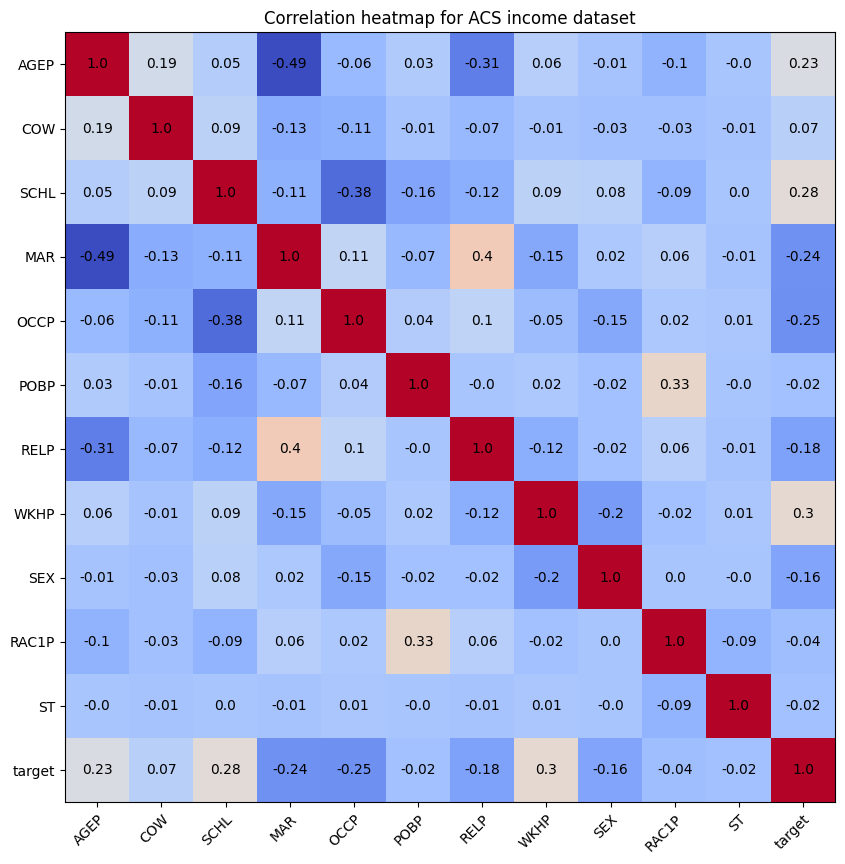

In [66]:
def test_plot_corr_heatmap():
    """Test plot_corr_heatmap function."""
    plot_corr_heatmap(DATA[ACS_INCOME]["features"], DATA[ACS_INCOME]["labels"],
                      "Correlation heatmap for ACS income dataset", PLOTS_PATH)


# test_plot_corr_heatmap()

In [67]:
def plot_target_dist(target, xlabel, ylabel, title, save_path=None):
    """Plot target distribution in a bar chart.
    
    Args:
        target (pd.Series): series
        xlabel (str): x-axis label
        ylabel (str): y-axis label
        title (str): title of the plot
    """
    print(target.describe())
    fig, ax = plt.subplots()
    ax.hist(target / 1000, bins=50)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if save_path:
        fig.savefig(save_path + title + ".png", bbox_inches='tight')
    return fig

count    1.664500e+06
mean     5.666386e+04
std      7.306745e+04
min      1.040000e+02
25%      2.000000e+04
50%      3.900000e+04
75%      6.800000e+04
max      1.423000e+06
Name: PINCP, dtype: float64


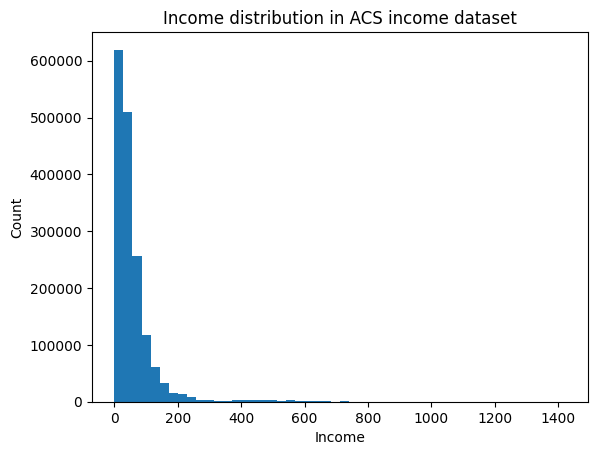

In [68]:
def test_plot_target_dist():
    """Test plot_target_distribution function."""
    plot_target_dist(DATA[ACS_INCOME]["labels"], 'Income', 'Count',
                     'Income distribution in ACS income dataset', PLOTS_PATH)
    

test_plot_target_dist()

## Data processing

In [69]:
def num_to_percentile_category(target, num_classes=4):
    """Convert numerical target to categorical target based on quantile.
    
    Args:
        target (pd.Series): target series
        num_classes (int): number of classes
    
    Returns:
        target (pd.Series): categorical target series
    """
    y_true_categorical = pd.qcut(target, num_classes, labels=range(num_classes))
    return y_true_categorical

In [70]:
def test_num_to_percentile_category():
    """Test num_to_percentile_category function."""
    DATA[ACS_INCOME]["quartiles"] = num_to_percentile_category(DATA[ACS_INCOME]["labels"], 4)
    DATA[ACS_INCOME]["binary"] = num_to_percentile_category(DATA[ACS_INCOME]["labels"], 2)


test_num_to_percentile_category()

## Classifiers

In [71]:
def train_classic_sklearn_clf(clf_choice, features, labels):
    """Train a classic classifier from sklearn on the dataset.
    
    Args:
        clf_choice (str): classifier choice
        num_classes (int): number of classes
        features (pd.Dataframe): features dataframe
        labels (pd.Series): labels series
    
    Returns:
        clf (sklearn.classifier): classifier
    """
    if clf_choice == "decision_tree_clf":
        clf = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
    
    clf.fit(features, labels)
    return clf

In [72]:
def test_train_classic_sklearn_clf():
    """Test train_classic_sklearn_clf function."""
    DATA[ACS_INCOME]["decision_tree_clf_4"] = train_classic_sklearn_clf("decision_tree_clf",
                                                                        DATA[ACS_INCOME]["features"],
                                                                        DATA[ACS_INCOME]["quartiles"])
    DATA[ACS_INCOME]["decision_tree_clf_2"] = train_classic_sklearn_clf("decision_tree_clf",
                                                                        DATA[ACS_INCOME]["features"],
                                                                        DATA[ACS_INCOME]["binary"])


test_train_classic_sklearn_clf()

In [73]:
def plot_decision_tree(clf, features, labels, title, save_path=None):
    """Plot decision tree.
    
    Args:
        clf (sklearn.classifier): classifier
        features (pd.Dataframe): features dataframe
        labels (pd.Series): labels series
        title (str): title of the plot
        save_path (str): path to save the plot
    
    Returns:
        fig (matplotlib.figure.Figure): figure
    """
    fig, ax = plt.subplots(figsize=(20, 20))
    class_names = [str(label) for label in list(labels.unique())] 
    plot_tree(clf, ax=ax, feature_names=features.columns, class_names=class_names, filled=True)
    if save_path:
        fig.savefig(save_path + title + ".pdf", bbox_inches='tight')
    return fig

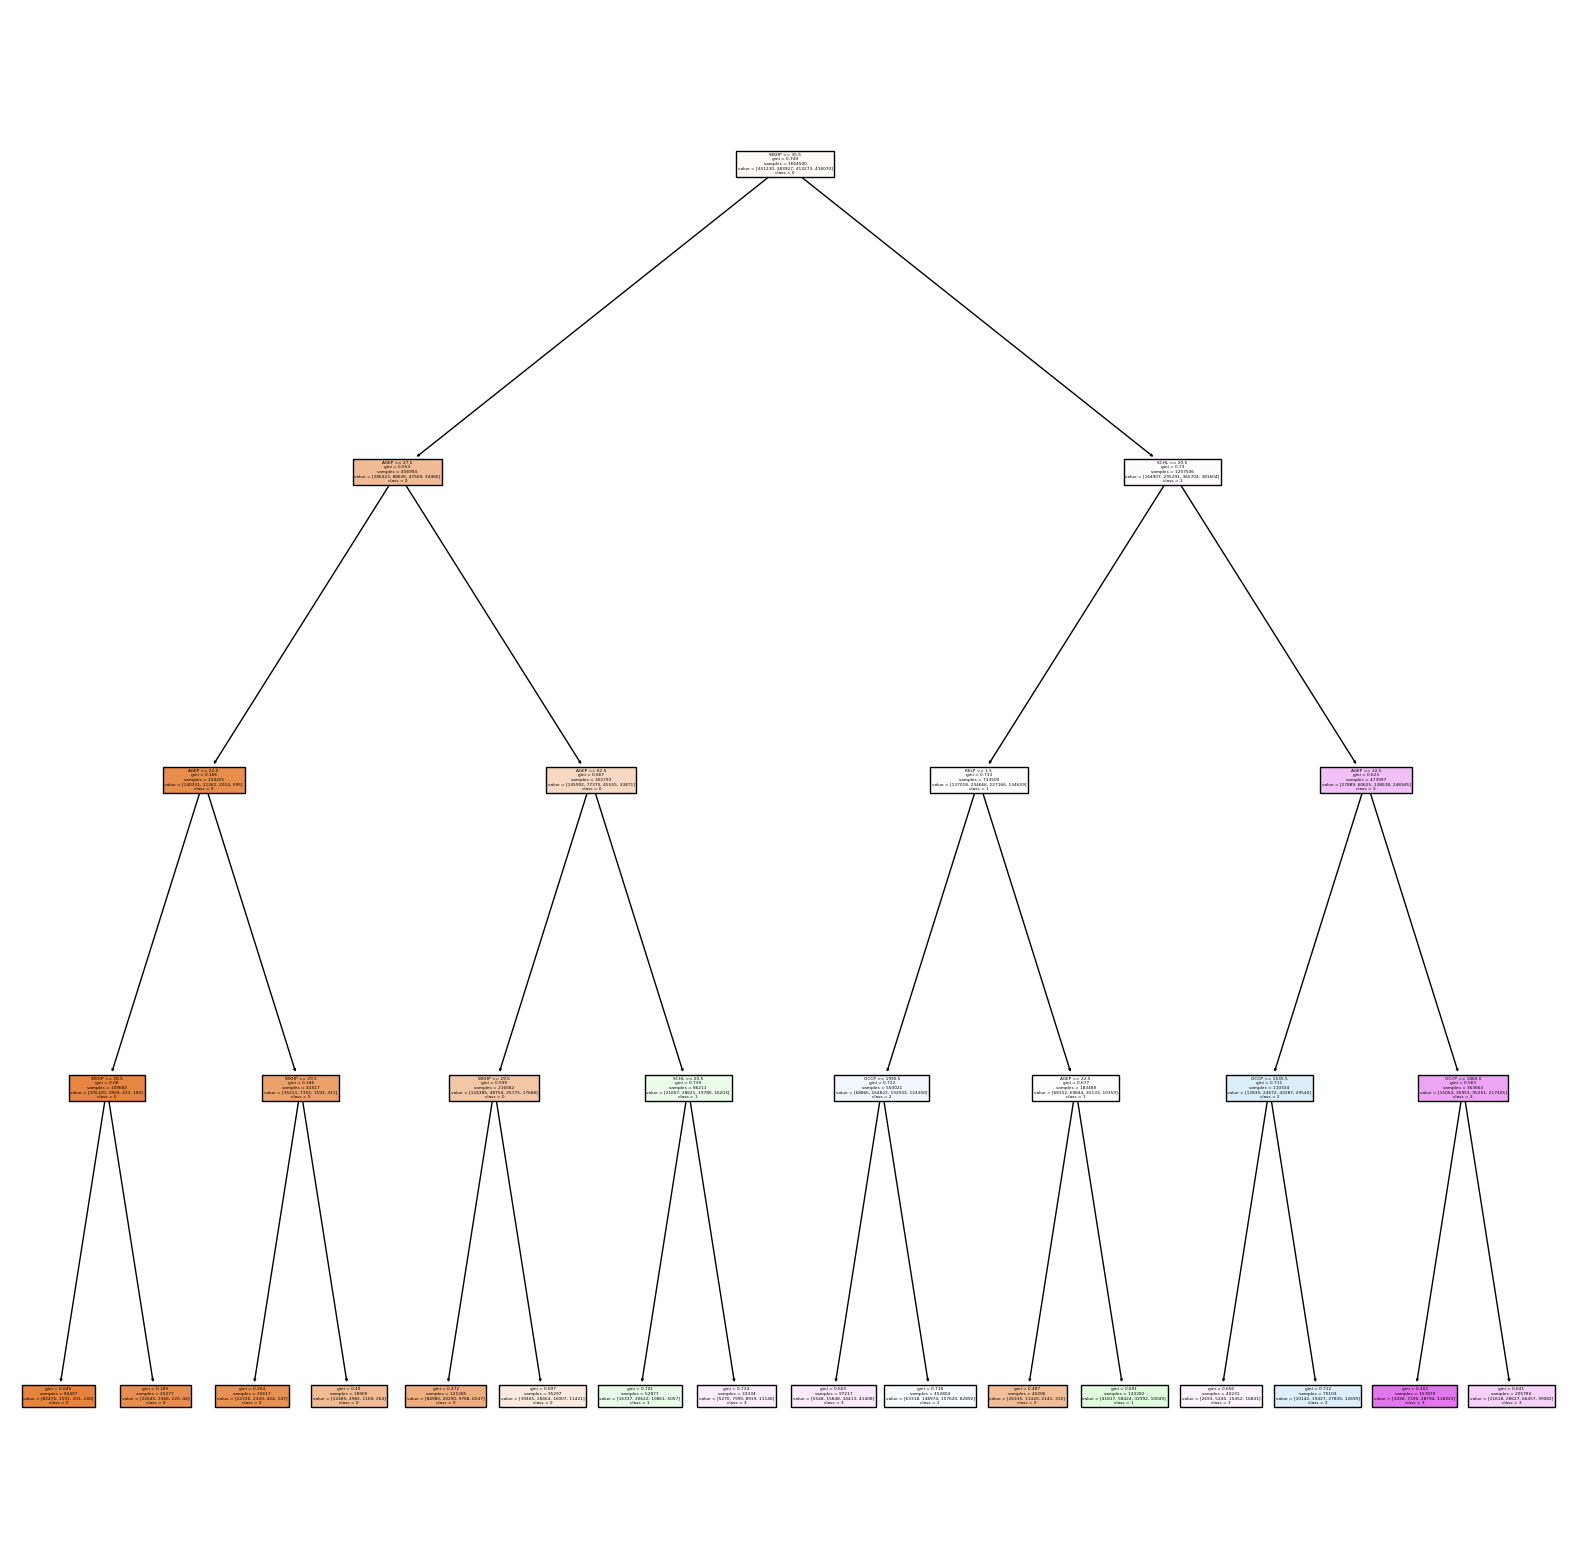

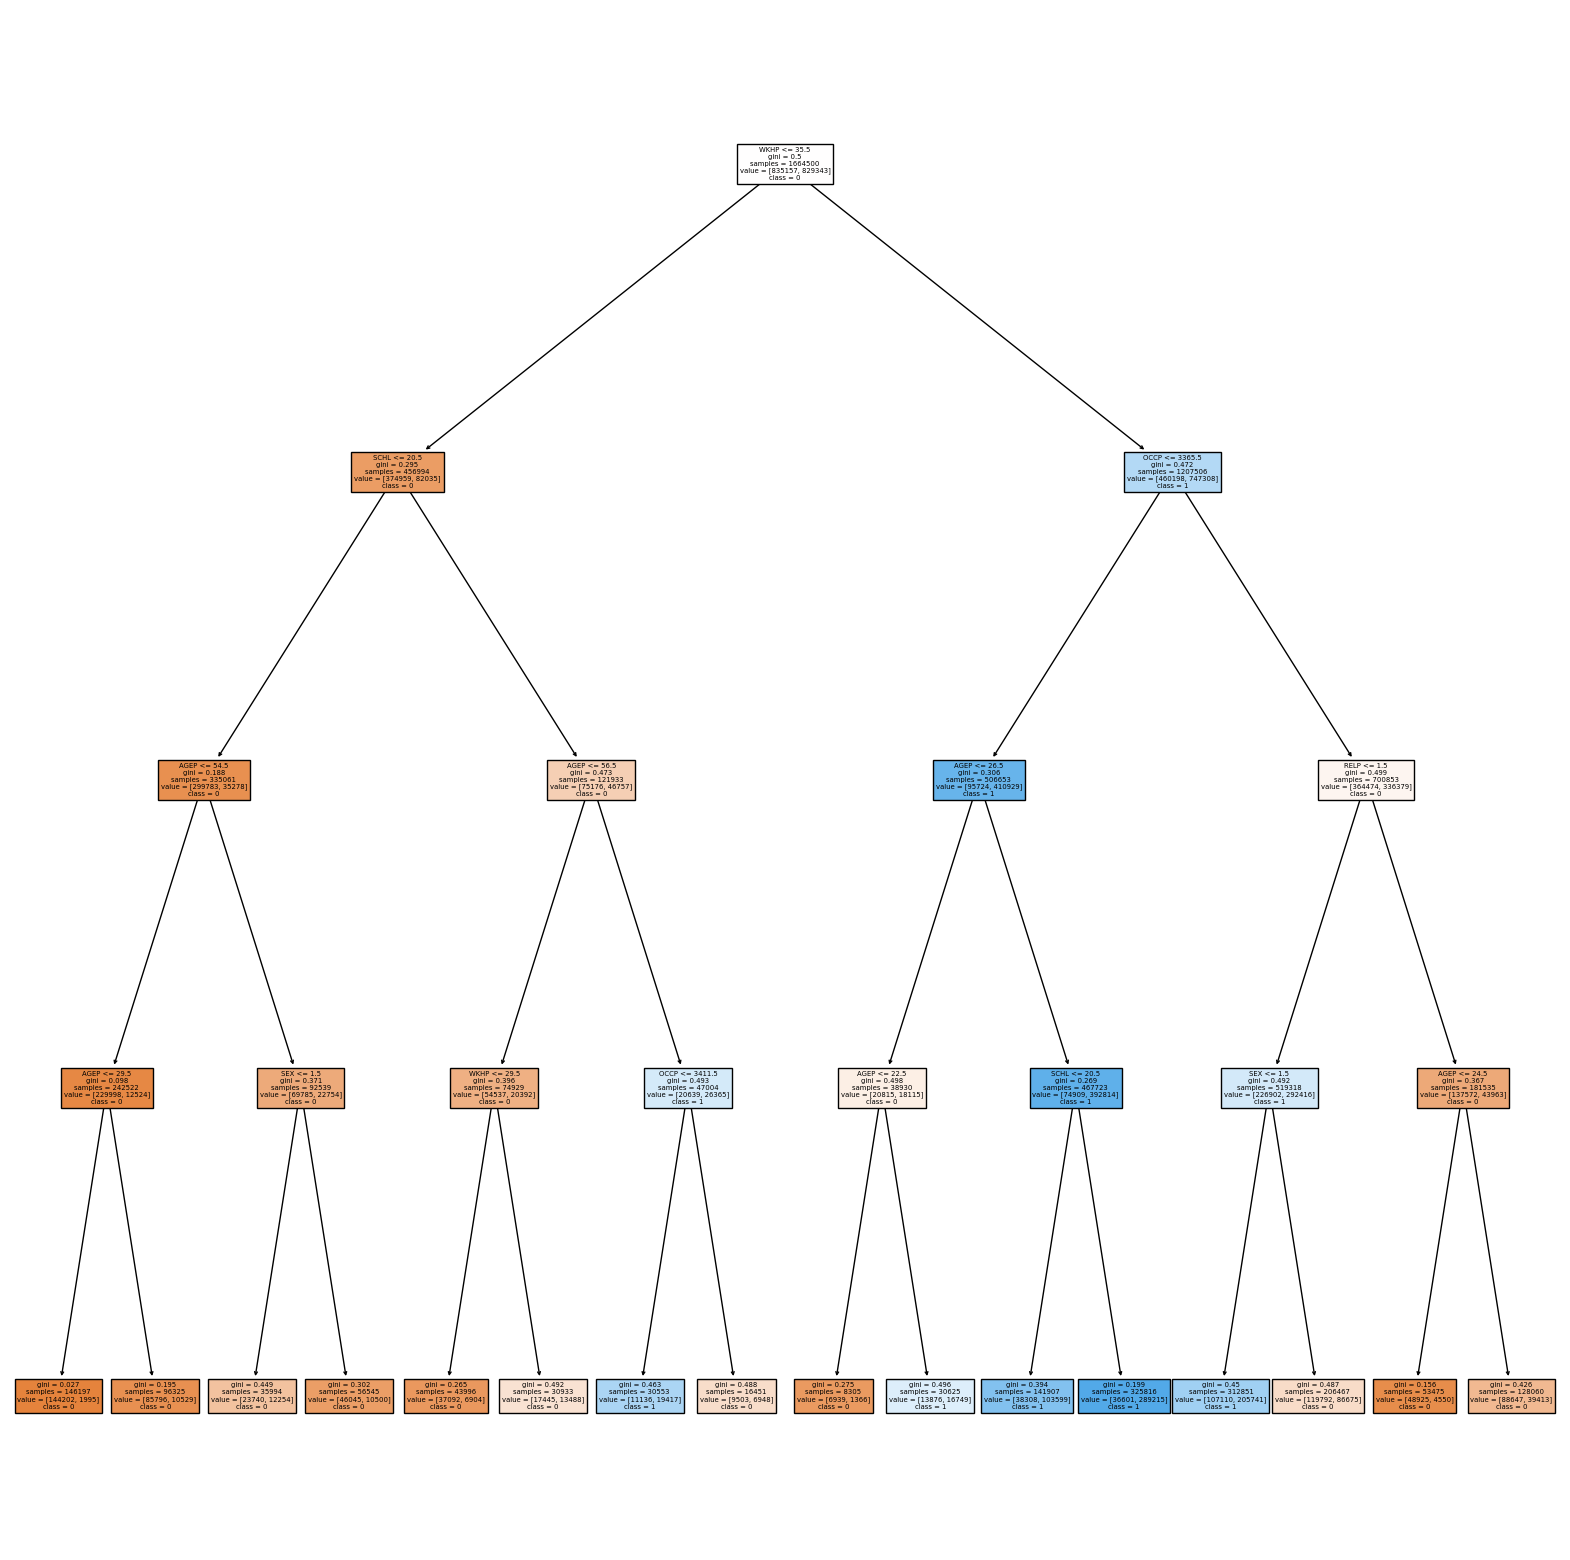

In [74]:
def test_plot_decision_tree():
    """test plot_decision_tree function."""
    plot_decision_tree(DATA[ACS_INCOME]["decision_tree_clf_4"], DATA[ACS_INCOME]["features"],
                       DATA[ACS_INCOME]["quartiles"], "Quartile decision tree for ACS income dataset",
                       PLOTS_PATH)
    plot_decision_tree(DATA[ACS_INCOME]["decision_tree_clf_2"], DATA[ACS_INCOME]["features"],
                       DATA[ACS_INCOME]["binary"], "Binary decision tree for ACS income dataset",
                       PLOTS_PATH)

test_plot_decision_tree()

## Fairness assessment

Choose sensitive features and assess the fairness of predictions.

In [75]:
def customized_classification_report(y_true, y_pred, output_dict=True):
    """Customized classification report.
    
    Args:
        y_true (pd.Series): true labels
        y_pred (pd.Series): predicted labels
        output_dict (bool): whether to output dictionary
    """
    return classification_report(y_true, y_pred, output_dict=output_dict)

In [76]:
def eval_multi_clf_fairness(clf, features, labels, sensitive_features):
    """Evaluate fairness of the multi-class classifier.
    
    Args:
        clf (sklearn.classifier): classifier
        features (pd.Dataframe): features dataframe
        labels (pd.Series): labels series
        sensitive_features (pd.Series): sensitive features series
        metrics (dict): dictionary of evaluation metrics
    """
    y_pred = clf.predict(features)
    metrics = {
        "accuracy": accuracy_score,
        "confusion matrix": confusion_matrix,
        "classication report": customized_classification_report
    }
    metric_frame = MetricFrame(metrics=metrics,
                               y_true=labels,
                               y_pred=y_pred,
                               sensitive_features=sensitive_features)
    return metric_frame

In [77]:
def test_eval_multi_clf_fairness():
    """Test eval_multi_clf_fairness function."""
    DATA[ACS_INCOME]["decision_tree_clf_4_metrics"] = eval_multi_clf_fairness(
        DATA[ACS_INCOME]["decision_tree_clf_4"],
        DATA[ACS_INCOME]["features"],
        DATA[ACS_INCOME]["quartiles"],
        DATA[ACS_INCOME]["features"]["RAC1P"]  # sensitive features
    )


test_eval_multi_clf_fairness()

In [78]:
DATA[ACS_INCOME]["decision_tree_clf_4_metrics"].by_group

,accuracy,confusion matrix,classication report
RAC1P,,,
1.0,0.509623,"[[215753, 40380, 51463, 21712], [54644, 58238,...","{'0': {'precision': 0.6970139465463157, 'recal..."
2.0,0.463764,"[[30955, 8756, 9701, 2339], [6563, 9179, 19015...","{'0': {'precision': 0.7560141653437538, 'recal..."
3.0,0.442332,"[[2394, 801, 896, 198], [512, 844, 1671, 451],...","{'0': {'precision': 0.7638800255264837, 'recal..."
4.0,0.515453,"[[283, 71, 58, 9], [80, 61, 49, 16], [33, 28, ...","{'0': {'precision': 0.6953316953316954, 'recal..."
5.0,0.485266,"[[496, 129, 144, 42], [105, 173, 281, 66], [26...","{'0': {'precision': 0.779874213836478, 'recall..."
6.0,0.554798,"[[15999, 2445, 3935, 2766], [3545, 3077, 6722,...","{'0': {'precision': 0.7015259142330965, 'recal..."
7.0,0.457519,"[[506, 161, 140, 34], [164, 236, 372, 79], [40...","{'0': {'precision': 0.6903137789904502, 'recal..."
8.0,0.456065,"[[13635, 3728, 5283, 779], [3545, 5223, 10066,...","{'0': {'precision': 0.7430112800392349, 'recal..."
9.0,0.530121,"[[11030, 1683, 1840, 686], [2277, 2015, 3908, ...","{'0': {'precision': 0.7639562266241862, 'recal..."


In [79]:
def eval_binary_clf_fairness(clf, features, labels, sensitive_features):
    """Evaluate fairness of the binary classifier.
    
    Args:
        clf (sklearn.classifier): classifier
        features (pd.Dataframe): features dataframe
        labels (pd.Series): labels series
        sensitive_features (pd.Series): sensitive features series
    
    Returns:
        metric_frame (fairlearn.metrics.MetricFrame): metric frame
    """
    y_pred = clf.predict(features)
    metrics = {
        "accuracy": accuracy_score,
        "precision": precision_score,
        "confusion matrix": confusion_matrix,
        "classification report": customized_classification_report,
        "count": count,
        "mean prediction": mean_prediction,
        "selection rate": selection_rate,
        "false negative rate": false_negative_rate,
        "false positive rate": false_positive_rate,
        "true negative rate": true_negative_rate,
        "true positive rate": true_positive_rate
    }
    metric_frame = MetricFrame(metrics=metrics,
                               y_true=labels,
                               y_pred=y_pred,
                               sensitive_features=sensitive_features)
    return metric_frame

In [80]:
def test_eval_binary_clf_fairness():
    """Test eval_binary_clf_fairness function."""
    DATA[ACS_INCOME]["decision_tree_clf_2_metrics"] = eval_binary_clf_fairness(
        DATA[ACS_INCOME]["decision_tree_clf_2"],
        DATA[ACS_INCOME]["features"],
        DATA[ACS_INCOME]["binary"],
        DATA[ACS_INCOME]["features"]["RAC1P"]  # sensitive features
    )


test_eval_binary_clf_fairness()

In [125]:
DATA[ACS_INCOME]["decision_tree_clf_2_metrics"].by_group

,accuracy,precision,confusion matrix,classification report,count,mean prediction,selection rate,false negative rate,false positive rate,true negative rate,true positive rate
RAC1P,,,,,,,,,,,
1.0,0.760720,0.769654,"[[462345, 157174], [153441, 525166]]","{'0': {'precision': 0.750820902066627, 'recall...",1298126,0.525635,0.525635,0.226112,0.253703,0.746297,0.773888
2.0,0.740291,0.646419,"[[71948, 20402], [17924, 37299]]","{'0': {'precision': 0.8005607975787787, 'recal...",147573,0.391000,0.391000,0.324575,0.220920,0.779080,0.675425
3.0,0.735425,0.599227,"[[5798, 1969], [1176, 2944]]","{'0': {'precision': 0.8313736736449671, 'recal...",11887,0.413309,0.413309,0.285437,0.253508,0.746492,0.714563
4.0,0.768212,0.638554,"[[537, 90], [120, 159]]","{'0': {'precision': 0.817351598173516, 'recall...",906,0.274834,0.274834,0.430108,0.143541,0.856459,0.569892
5.0,0.740970,0.579355,"[[1110, 326], [219, 449]]","{'0': {'precision': 0.835214446952596, 'recall...",2104,0.368346,0.368346,0.327844,0.227019,0.772981,0.672156
6.0,0.775620,0.798090,"[[32222, 10764], [10866, 42547]]","{'0': {'precision': 0.7478184181210545, 'recal...",96399,0.553024,0.553024,0.203434,0.250407,0.749593,0.796566
7.0,0.722716,0.653465,"[[1307, 385], [395, 726]]","{'0': {'precision': 0.7679200940070505, 'recal...",2813,0.394952,0.394952,0.352364,0.227541,0.772459,0.647636
8.0,0.728708,0.540560,"[[32878, 10999], [6059, 12941]]","{'0': {'precision': 0.8443896550838534, 'recal...",62877,0.380743,0.380743,0.318895,0.250678,0.749322,0.681105
9.0,0.776540,0.717321,"[[19981, 4922], [4422, 12490]]","{'0': {'precision': 0.8187927713805679, 'recal...",41815,0.416406,0.416406,0.261471,0.197647,0.802353,0.738529


In [147]:
def plot_binary_fairness_metrics_by_group(metric_frame, xticks, title, save_path=None):
    """Plot binary fairness metrics by group.
    
    Args:
        metric_frame (fairlearn.metrics.MetricFrame): metric frame
        xticks (list): x-axis ticks
        title (str): title of the plot
        save_path (str): path to save the plot
    """
    plt.figure(figsize=(18, 18))
    reindexed_metric_frame = metric_frame.by_group.copy()
    reindexed_metric_frame.index = xticks
    reindexed_metric_frame.index.name = metric_frame.by_group.index.name
    reindexed_metric_frame[["accuracy",
                            "precision",
                            "count",
                            "mean prediction",
                            "selection rate",
                            "false negative rate",
                            "false positive rate",
                            "true negative rate",
                            "true positive rate"]
                           ].plot(
                               kind="bar",
                               subplots=True,
                               layout=[3, 3],
                               legend=False,
                               figsize=[12, 8],
                               rot=45,
                               position=0,
                               title=title)
    if save_path:
        plt.savefig(save_path + title + ".png", bbox_inches='tight')

<Figure size 1800x1800 with 0 Axes>

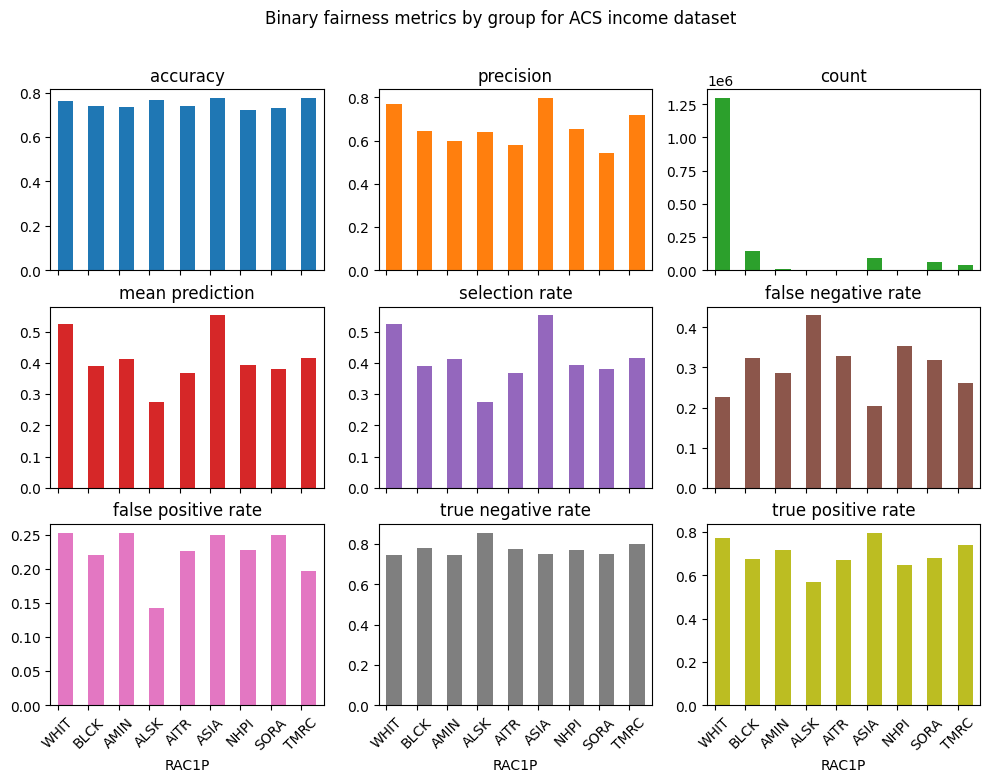

In [148]:
def test_plot_binary_fairness_metrics_by_group():
    """Test plot_binary_fairness_metrics_by_group function."""
    plot_binary_fairness_metrics_by_group(DATA[ACS_INCOME]["decision_tree_clf_2_metrics"],
                                          RACIP_CODES,
                                          "Binary fairness metrics by group for ACS income dataset",
                                          PLOTS_PATH)
    

test_plot_binary_fairness_metrics_by_group()